In [4]:
import pandas as pd, geopandas as gpd, json, numpy as np
import networkx as nx, matplotlib.pyplot as plt, matplotlib as mpl, contextily as ctx
from shapely import wkt
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path

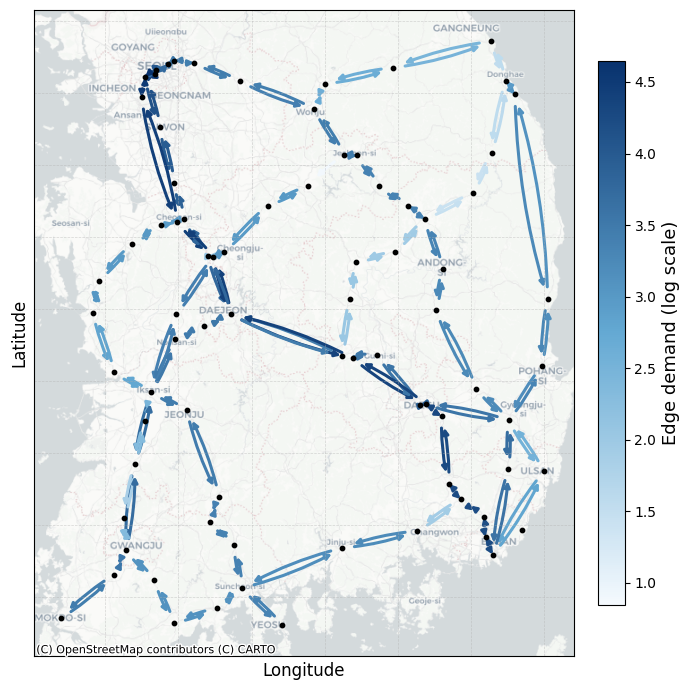

In [5]:
# ───────────────────────── Set paths ─────────────────────────
BASE         = Path(r"D:\MINJI\NETWORK RELIABILITY\QGIS\7.Korea_Full")
xlsx_fp      = BASE / "qgis_export.xlsx"
json_fp      = BASE / r"json\demand_fig.json"      
# -------------------------------------------------------------------------

# 1. Load NODE / EDGE sheets 
node_df = pd.read_excel(xlsx_fp, sheet_name="NODE",
                        usecols=["node_id", "geometry"])
edge_df = pd.read_excel(xlsx_fp, sheet_name="EDGE",
                        usecols=["edge_id", "from_node_id", "to_node_id",
                                 "distance", "geom_line"])

node_gdf = gpd.GeoDataFrame(
    node_df.assign(geometry=node_df["geometry"].apply(wkt.loads)),
    geometry="geometry", crs="EPSG:4326"
).to_crs(epsg=3857)

edge_gdf = gpd.GeoDataFrame(
    edge_df.assign(geometry=edge_df["geom_line"].apply(wkt.loads)),
    geometry="geometry", crs="EPSG:4326"
).to_crs(epsg=3857)

# Coordinates dictionary  { "n1": (x, y) }
nodes = {f"n{int(r.node_id)}": (r.geometry.x, r.geometry.y)
         for r in node_gdf.itertuples(index=False)}

# Bidirectional edge dictionary
edges, arc_dist = {}, {}
for r in edge_gdf.itertuples(index=False):
    u_id, v_id = int(r.from_node_id), int(r.to_node_id)
    u, v       = f"n{u_id}", f"n{v_id}"
    d_km       = float(r.distance)

    eid_fwd = f"{r.edge_id}:{u_id}->{v_id}"
    eid_rev = f"{r.edge_id}:{v_id}->{u_id}"
    edges[eid_fwd], edges[eid_rev] = (u, v), (v, u)
    arc_dist[eid_fwd] = arc_dist[eid_rev] = d_km

# 2. Build DiGraph
G = nx.DiGraph()
for n, xy in nodes.items():
    G.add_node(n, pos=xy)
for eid, (u, v) in edges.items():
    G.add_edge(u, v, weight=arc_dist[eid])

# 3. Parse demand JSON 
with open(json_fp, encoding="utf-8") as f:
    jd = json.load(f)

records = []

if isinstance(jd, list):
    # Format A: [{ "origin": "n1", "destination": "n2", "journeys": 123, ...}, ...]
    for rec in jd:
        o = rec.get("origin") or rec.get("origin_name")
        d = rec.get("destination") or rec.get("destination_name")
        j = rec.get("journeys", 0)
        if o and d:
            records.append((o, d, j))

elif isinstance(jd, dict):
    # Format B: { "LineName": [["n1","n2",123], ...], ... }
    for lst in jd.values():
        for o, d, j in lst:
            records.append((o, d, j))

else:
    raise ValueError("Unsupported JSON structure.")

# 4. Accumulate demand for each edge 
edge_demand = {e: 0.0 for e in G.edges}

for o, d, j in records:
    try:
        paths = list(nx.all_shortest_paths(G, o, d, weight="weight"))
        share = j / len(paths)
        for p in paths:
            for u, v in zip(p[:-1], p[1:]):
                edge_demand[(u, v)] += share
    except nx.NetworkXNoPath:
        print(f"⚠️ No path {o} → {d}")

# 5. Log-scale normalization, colormap 
logd = {e: np.log10(v + 1) for e, v in edge_demand.items()}
dmin, dmax = min(logd.values()), max(logd.values())
normd = {e: (v - dmin) / (dmax - dmin) if dmax > dmin else 0
         for e, v in logd.items()}

cmap = LinearSegmentedColormap.from_list(
    "grad", [(245/255,250/255,254/255),
             (100/255,169/255,211/255),
             (8/255,50/255,110/255)])

# 6. Visualization 
fig, ax = plt.subplots(figsize=(7, 7))
pos = nx.get_node_attributes(G, "pos")

for (u, v), val in normd.items():
    if val == 0:
        continue
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)],
        width=2.2, edge_color=[cmap(val)],
        arrowstyle="-|>", arrowsize=8,
        connectionstyle="arc3,rad=0.07", ax=ax
    )

# ── Draw nodes 
nodes_pc = nx.draw_networkx_nodes(
    G, pos, node_size=10, node_color="black", ax=ax
)
nodes_pc.set_zorder(3)     

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron,
                crs="EPSG:3857", zorder=0)

sm = mpl.cm.ScalarMappable(cmap=cmap,
        norm=mpl.colors.Normalize(vmin=dmin, vmax=dmax))
sm.set_array([])
plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)\
    .set_label("Edge demand (log scale)", fontsize=13)

ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
plt.tight_layout()
plt.show()

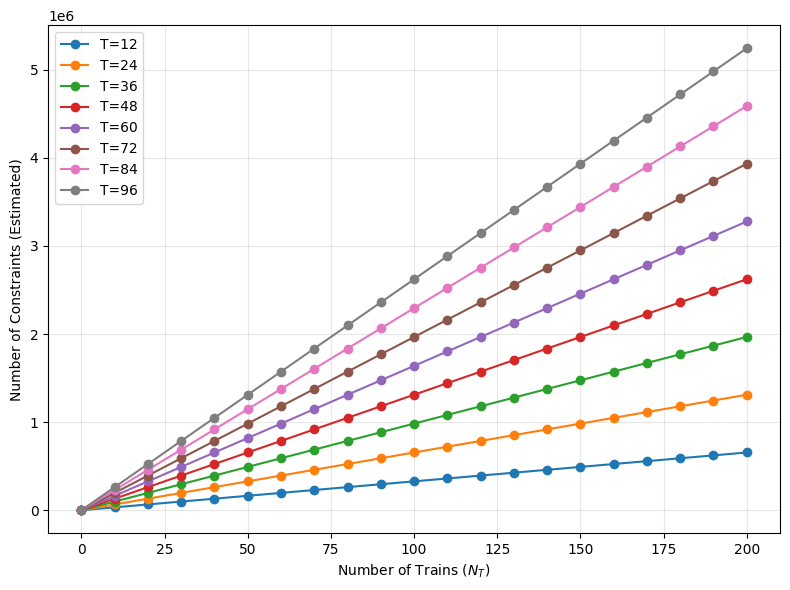

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------- 0. 기본 데이터 --------
N_OD = 500
N_N, N_E = 81, 192
N_T_vals = np.arange(0, 201, 10)      # 0‥195, step 10
T_vals   = np.arange(12, 97, 12)      # 12‥96, step 12
NT, TT   = np.meshgrid(N_T_vals, T_vals)
Z        = NT * TT * (N_N + N_E) + N_OD

plt.figure(figsize=(8,6))
for t in T_vals:
    Z_slice = Z[T_vals==t, :].ravel()      
    plt.plot(N_T_vals, Z_slice, marker='o', label=f'T={t}')

plt.xlabel(r'Number of Trains ($N_T$)')
plt.ylabel('Number of Constraints (Estimated)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Figure (메인코드 뒤에 붙이기)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
import matplotlib as mpl

# 1. 한글 깨짐 방지
mpl.rcParams['font.family'] = 'Malgun Gothic'      # 윈도우 기준
mpl.rcParams['axes.unicode_minus'] = False

# 2. 그래프
fig, ax = plt.subplots(figsize=(12, len(df['Train'].unique()) * 0.15))  # 더 얇게

train_ids = df['Train'].unique()
train_to_y = {train: i for i, train in enumerate(train_ids)}

for _, row in df.iterrows():
    ax.broken_barh([(row['Dep'], row['Arr'] - row['Dep'])], 
                   (train_to_y[row['Train']] - 0.3, 0.6),  # 얇은 막대
                   facecolors='tab:blue')

ax.set_yticks(list(train_to_y.values()))
ax.set_yticklabels(train_ids)
ax.set_xlabel("Time")
ax.set_ylabel("Train")
ax.set_title("Train Timetable")
ax.grid(True, axis='x', linestyle='--', alpha=0.6)

ax.xaxis.set_major_locator(ticker.MultipleLocator(12))  # 시간 간격
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns

# From 기준 시간대 정류 수 카운트
heat_data = df.groupby(['Dep', 'From']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(heat_data.T, cmap='Blues', linewidths=0.1, linecolor='gray')
plt.title("Number of Departures per Node over Time")
plt.xlabel("Time")
plt.ylabel("Station (From)")
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# timestep_flow_plot.py
# ----------------------
# (1) Gurobi 결과에서 시점별 edge-flow 계산
# (2) QGIS에서 export한 엑셀·JSON으로 좌표·수요 읽기
# (3) contextily + networkx 로 지도 시각화
# ============================================================

import json, math, itertools, contextily as ctx
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import networkx as nx
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
from shapely import wkt
from collections import defaultdict

# ============================================================
# 0. 사용자 설정
# ============================================================
BASE      = Path(r"D:\MINJI\NETWORK RELIABILITY\QGIS\7.Korea_Full\json")
xlsx_fp   = BASE / "qgis_export.xlsx"
json_fp   = BASE / r"json\demand_fig.json"
flow_type = "trains"    # "trains" (x합)  /  "pax" (승객수)

# ============================================================
# 1. Gurobi 결과 처리
# ============================================================
# (1-A) 시점 t_focus 에서 사용 중인 arc → 열차 수 or 승객 수
# ------------------------------------------------------------
def split_node_time(s):
    """
    "n123^7"  → ("n123", 7)
    "n123"    → ("n123", None)
    123       → ("n123", None)
    "SINK"    → ("SINK", None)
    """
    if isinstance(s, (int, np.integer)):
        return f"n{int(s)}", None
    s = str(s)
    if "^" in s:
        node, t = s.split("^", 1)
        return node, int(t)
    if s.isdigit():
        return f"n{int(s)}", None
    return s, None

# --------------------------- 설정 ---------------------------
t_focus    = 12
cumulative = True    # True: 누적합산 / False: 시점별

edge_flow_t = defaultdict(float)

for (idx, ti), val in x_val.items():
    if val < 0.5:
        continue

    fr_str, to_str, eid = arc_list[idx][:3]
    if eid.startswith(("w_", "dummy")):
        continue

    u_raw, t_dep = split_node_time(fr_str)
    v_raw, t_arr = split_node_time(to_str)
    if t_dep is None or t_arr is None:
        continue

    cond = (t_dep <= t_focus) if cumulative else (t_dep <= t_focus < t_arr)
    if not cond:
        continue

    if flow_type == "trains":
        edge_flow_t[(u_raw, v_raw)] += 1
    else:
        tr_name = trains[ti]
        q_tot   = sum(q for _, _, q in demand[tr_name])
        edge_flow_t[(u_raw, v_raw)] += q_tot

# ============================================================
# 2. QGIS Export: 노드·엣지 좌표 읽기
# ============================================================
node_df = pd.read_excel(xlsx_fp, sheet_name="NODE", usecols=["node_id", "geometry"])
edge_df = pd.read_excel(xlsx_fp, sheet_name="EDGE", usecols=["edge_id", "from_node_id", "to_node_id", "geometry"])

node_gdf = gpd.GeoDataFrame(
    node_df.assign(geometry=node_df["geometry"].apply(wkt.loads)),
    geometry="geometry", crs="EPSG:4326"
).to_crs(epsg=3857)

edge_gdf = gpd.GeoDataFrame(
    edge_df.assign(geometry=edge_df["geometry"].apply(wkt.loads)),
    geometry="geometry", crs="EPSG:4326"
).to_crs(epsg=3857)

# 2-A. 노드 좌표 dict
pos = {f"n{int(r.node_id)}": (r.geometry.x, r.geometry.y) for r in node_gdf.itertuples(index=False)}

# 2-B. 엣지 (u,v) 쌍 및 양방향 처리
edges_bidir = {}
for r in edge_gdf.itertuples(index=False):
    u = f"n{int(r.from_node_id)}"
    v = f"n{int(r.to_node_id)}"
    edges_bidir[(u, v)] = r.geometry

for (u, v), geom in list(edges_bidir.items()):
    if (v, u) not in edges_bidir:
        edges_bidir[(v, u)] = geom

# ============================================================
# 3. NetworkX 그래프 생성
# ============================================================
G = nx.DiGraph()
for n, xy in pos.items():
    G.add_node(n, pos=xy)

for (u, v), geom in edges_bidir.items():
    flow = edge_flow_t.get((u, v), 0.0)
    if flow > 0:
        G.add_edge(u, v, weight=flow, geom=geom)

if not G.edges:
    print(f"No flow present at t={t_focus}. Showing empty network.")

# ============================================================
# 4. 색상 매핑 (log 스케일)
# ============================================================
flows = [d["weight"] for _, _, d in G.edges(data=True)]
logf  = [math.log10(f + 1) for f in flows]
vmin, vmax = min(logf), max(logf)
norm  = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap  = sns.color_palette("viridis", as_cmap=True)

# ============================================================
# 5. 시각화
# ============================================================
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor("white")

# 5-A. 지도 배경
xs, ys = zip(*pos.values())
ax.set_xlim(min(xs), max(xs))
ax.set_ylim(min(ys), max(ys))
ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.CartoDB.Positron, alpha=0.7)

# 5-B. 엣지 그리기
for (u, v, data), lf in zip(G.edges(data=True), logf):
    color = cmap(norm(lf))
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)],
        width=2.8, edge_color=[color],
        arrowstyle="-|>", arrowsize=9,
        connectionstyle="arc3,rad=0.07", ax=ax
    )

nx.draw_networkx_nodes(G, pos, node_size=18, node_color="black", ax=ax)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
label = "Trains" if flow_type == "trains" else "Passengers"
cbar.set_label(f"Flow at t={t_focus} ({label}, log scale)")

ax.set_title(f"Flow distribution at timestep t={t_focus}", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.show()